# Analisi del dataset credit card
Adesso applicheremo gli algoritmi PCA, autoencoder e denoising autoencoder ad un caso reale. Utilizzeremo un dataset ottenuto da Kaggle contenente le transazioni effettuate con carte di credito in due giorni nel settembre 2013 da titolari Europei.<br>
Nel dataset sono presenti 492 frodi su 284.807 transazioni, quindi è altamente sbilanciato: la classe positiva (frodi) rappresenta lo 0,172% di tutte le transazioni.<br>
Sono presenti solo variabili numeriche, che per motivi di privacy sono state trasformate attraverso PCA, e ne è stato nascosto il nome; le uniche variabili non trasformate sono il tempo trascorso (in secondi) tra ogni transazione e la prima transazione nel dataset, l'importo della transazione (in euro) e la classe, che ha valore 1 in caso di frode e 0 altrimenti.<br>
Possiamo osservare che solo queste 3 ultime variabili mostrano una correlazione con tutte le altre perchè non sono state coinvolte nella PCA.<br>
A causa delle dimensioni del dataset la Kernel PCA non è praticabile perchè richiede molta memoria RAM per essere eseguita, quindi non abbiamo applicato questo metodo.<br>
Dagli istogrammi si può vedere che nel caso delle transazioni normali sono presenti movimenti fino a 20000 euro e più l'importo è grande più diventano rare le transazioni. Al contrario, nelle transazioni fraudolente tutti gli importi sono molto bassi (il massimo in questo caso è 2500€), in quanto il truffatore cerca solitamente di non dare nell'occhio.<br>
Inoltre attraverso lo scatterplot che mette in relazione il tempo e l'importo, possiamo osservare che le transazioni fraudolente sono molto più variabili di quelle normali.<br>
Questa volta le anomalie sono disperse in tutto il dataset, quindi i grafici relativi a errore di ricostruzione e differenza tra dati originali e ricostuiti non è molto utile, invece la visualizzazione dell'errore di ricostruzione attraverso gli istogrammi mostra per tutti gli algoritmi che l'errore è piccolo per i dati normali mentre è grande per quelli anomali.<br>
Per ogni algoritmo è stato riportato il grafico che mette in relazione precision e recall al variare del threshold, il rilevamento delle anomalie con il thresold scelto e la matrice di confusione.<br>
Dai grafici possiamo osservare che PCA (con 15 compotenti principali) e l'autoencoder sparso con regolarizzazione (con 7 variabili latenti, $\lambda = 10^{-5}$) mostrano risultati quasi equivalenti scegliendo lo stesso threshold per rilevare le anomalie.<br>
Il denoising autoencoder (con 58 variabili latenti, $\lambda = 10^{-5}$) si dimostra l'algoritmo più performante per riconoscere la maggior parte delle anomalie e riconoscendo il minor numero di dati normali come anomali, scegliendo un threshold molto piccolo.<br>
Infine riportiamo la ROC finale dove al variare del threshold vediamo le prestazioni dei 3 algoritmi. Queste risultano abbastanza simili tra loro, ma si può notare come per threshold molto piccoli il denoising autoencoder ha i risultati migliori, seguito da PCA e poi dall'autoencoder sparso, mentre la situazione si ribalta per threshold più alti. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA, PCA
from path import Path
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lib.autoencoder import AutoEncoder
import lib.noisy as noisy
from pylab import rcParams
from sklearn.model_selection import train_test_split
#from keras.layers import LeakyReLU
import tensorflow as tf
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [3]:
def reconstruction_error(X, Y):
    return np.sqrt(np.mean((X - Y)**2, axis=1))

In [4]:
plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_random_seed(42)
LABELS = ["Normal", "Fraud"]

In [5]:
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
df = pd.read_csv(DATA_DIR / 'creditcard.csv' )

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


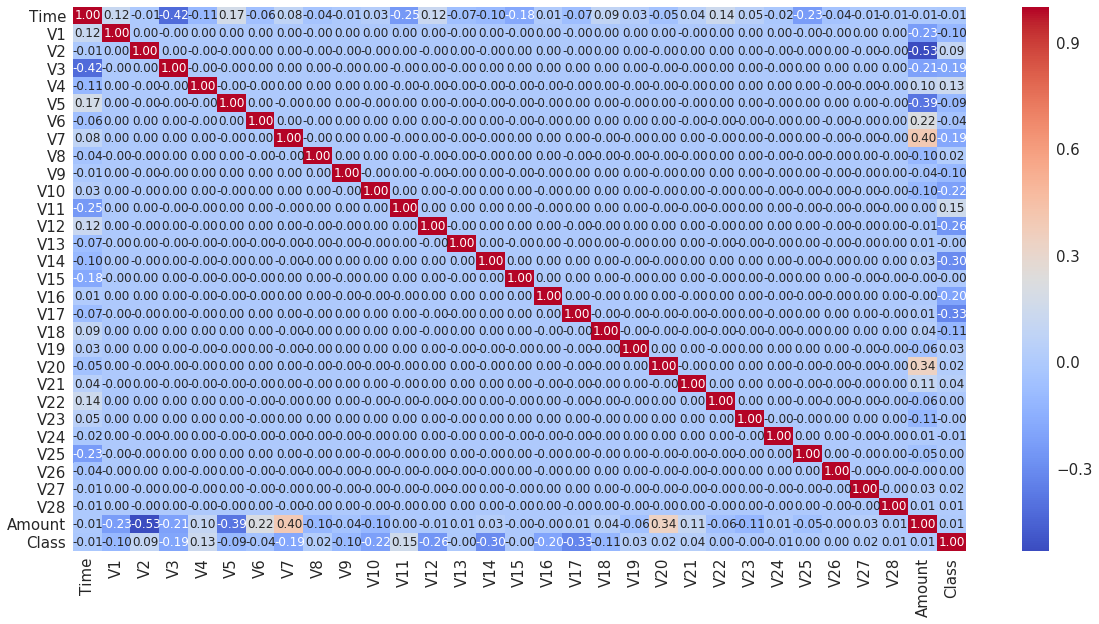

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(data=corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size':12})

Come annunciato il dataset è sbilanciato, gli esempi normali sono molto di più di quelli fraudolenti.

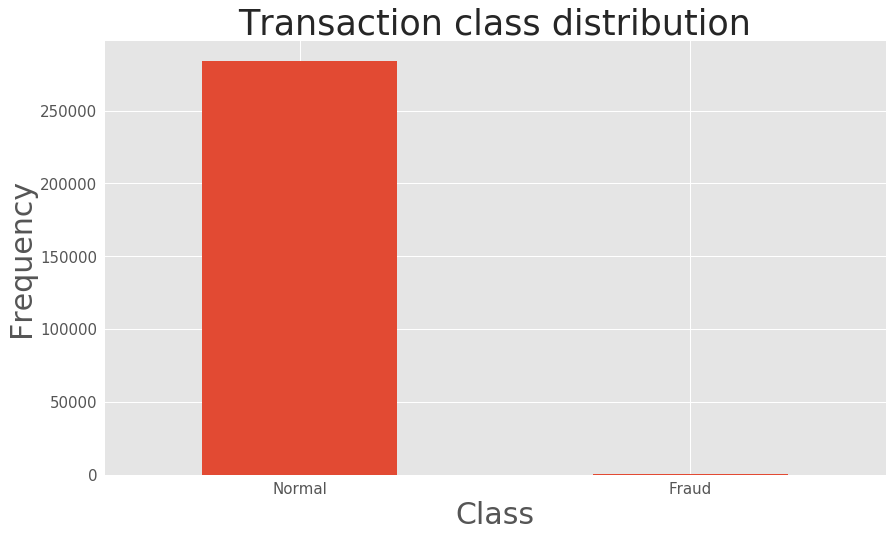

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
with plt.style.context('ggplot'):
    count_classes.plot(kind = 'bar', rot=0)
    plt.title("Transaction class distribution", size =35)
    plt.xticks(range(2), LABELS)
    plt.xlabel("Class", size = 30)
    plt.ylabel("Frequency", size =30)

In [10]:
frauds = df[df.Class == 1] # crea un dataset di soli casi frauddalenti
normal = df[df.Class == 0] # crea un dataset di soli casi  non frauddalenti
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

In [12]:
frauds.Amount.describe() #statistiche della colonna quantità di $ per i casi fraudolenti

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
normal.Amount.describe() #statistiche della colonna quantità di $ per i casi non fraudolenti

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

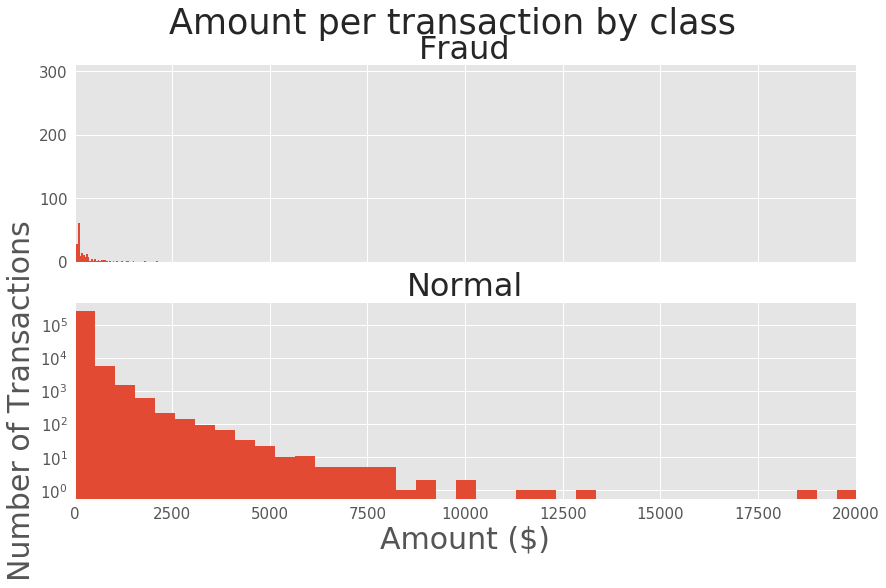

In [14]:
with plt.style.context('ggplot'):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Amount per transaction by class', size = 35)

    bins = 50

    ax1.hist(frauds.Amount, bins = bins)
    ax1.set_title('Fraud', size = 32)

    ax2.hist(normal.Amount, bins = bins)
    ax2.set_title('Normal', size = 32)

    plt.xlabel('Amount ($)', size = 30)
    plt.ylabel('Number of Transactions', size = 30)
    plt.xlim((0, 20000))
    plt.yscale('log')


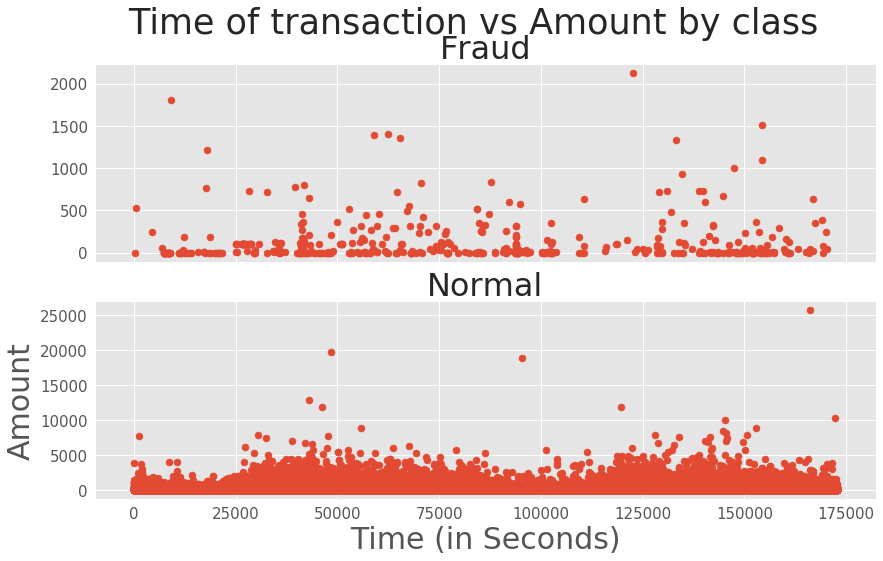

In [15]:
with plt.style.context('ggplot'):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Time of transaction vs Amount by class', size = 35)

    ax1.scatter(frauds.Time, frauds.Amount)
    ax1.set_title('Fraud', size = 32)

    ax2.scatter(normal.Time, normal.Amount)
    ax2.set_title('Normal', size = 32)

    plt.xlabel('Time (in Seconds)', size = 30)
    plt.ylabel('Amount', size = 30)


In [16]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [17]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(199008, 29)

In [18]:
X_train.shape[1]

29

In [19]:
PCA = PCA(n_components=15)

In [20]:
PCA.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
X_test_pca = PCA.transform(X_test)
X_projected_test = PCA.inverse_transform(X_test_pca)

In [22]:
np.sum(PCA.explained_variance_ratio_)

0.8173123599742338

In [23]:
error_e_test = np.sqrt(np.mean(np.power(X_test - X_projected_test, 2), axis=1))

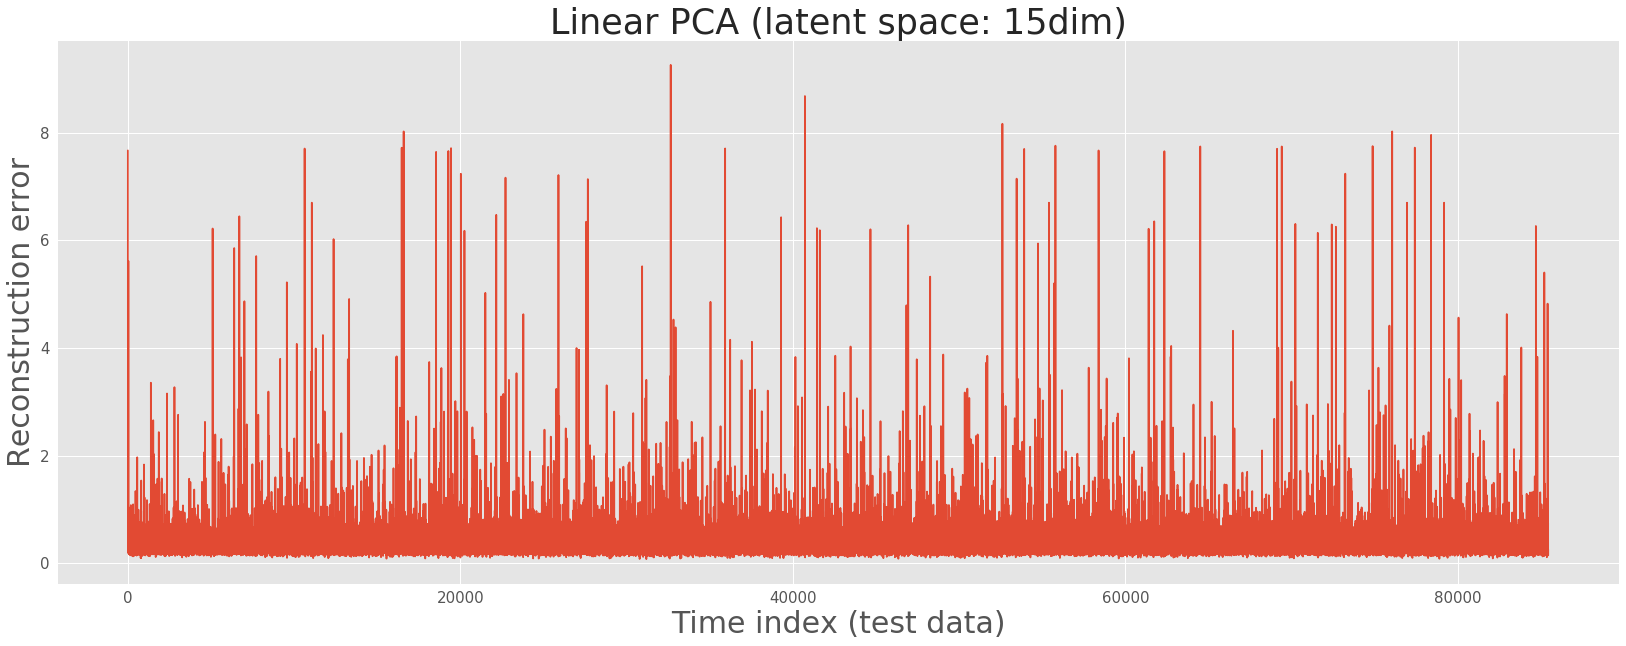

In [24]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(error_e_test)
    plt.title('Linear PCA (latent space: 15dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Reconstruction error', size=30)

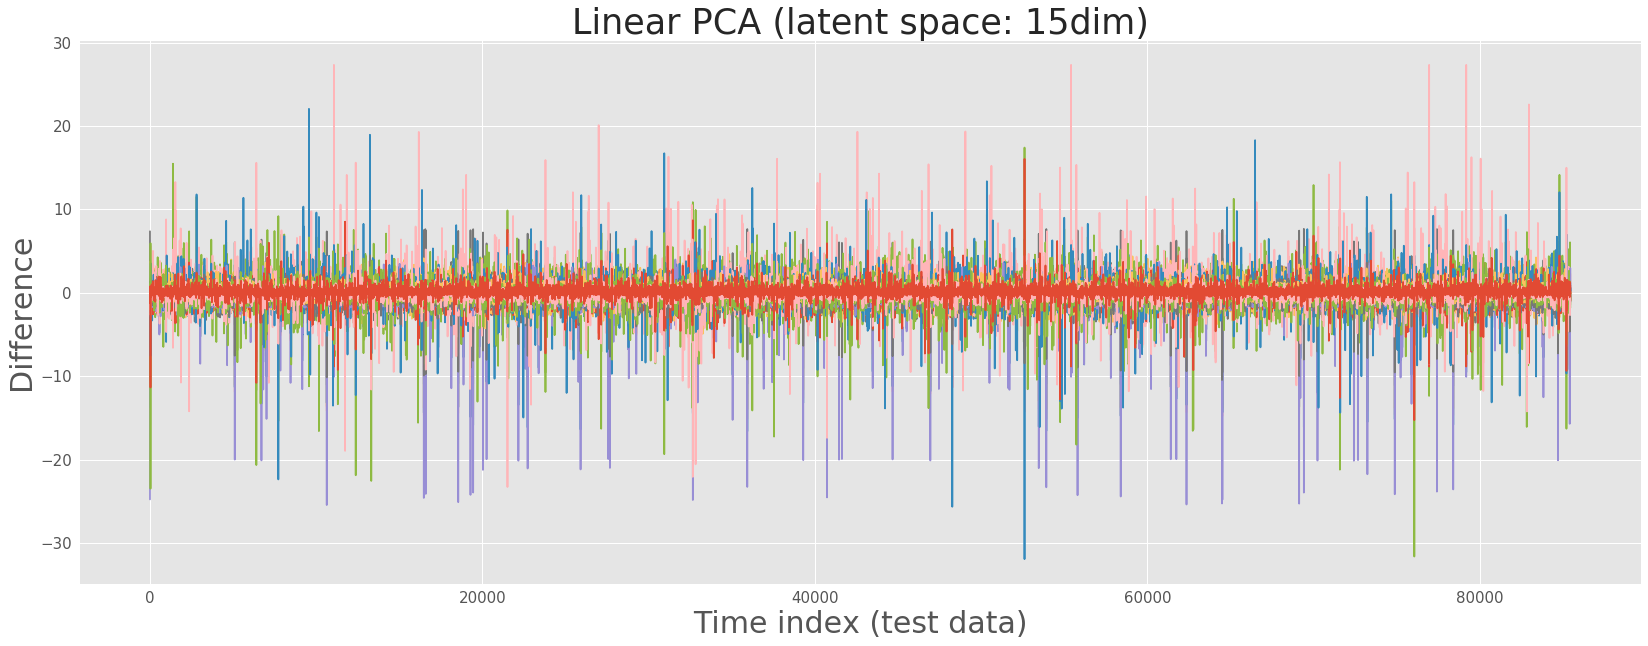

In [25]:
X=X_projected_test.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-X_projected_test)
    plt.title('Linear PCA (latent space: 15dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Difference', size=30)

In [26]:
rmse_pca = reconstruction_error(X_test, X_projected_test)
error_df_pca = pd.DataFrame({'reconstruction_error': rmse_pca,
                        'true_class': y_test})
error_df_pca.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.374306,0.001592
std,0.284680,0.039865
min,0.076136,0.000000
25%,0.245096,0.000000
50%,0.324163,0.000000
75%,0.433388,0.000000
max,9.260553,1.000000


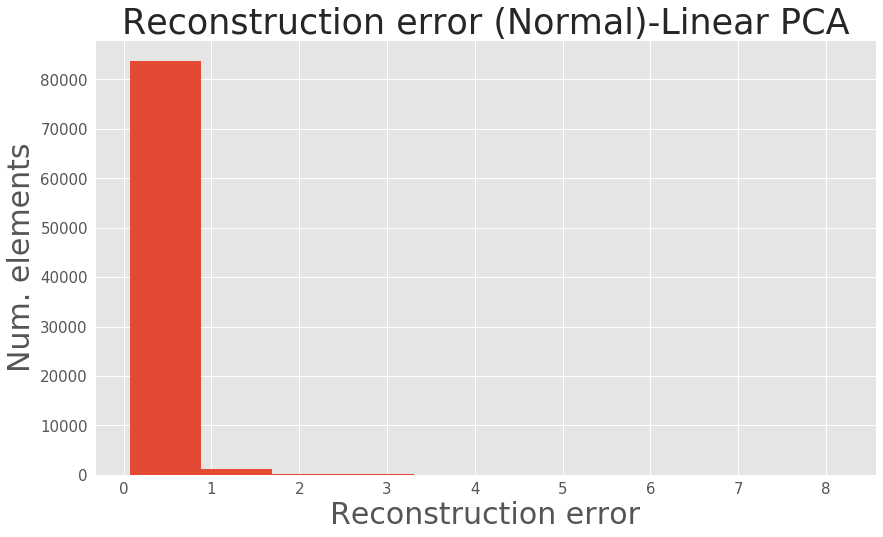

In [27]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_pca = error_df_pca[(error_df_pca['true_class']== 0) & (error_df_pca['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df_pca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)-Linear PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

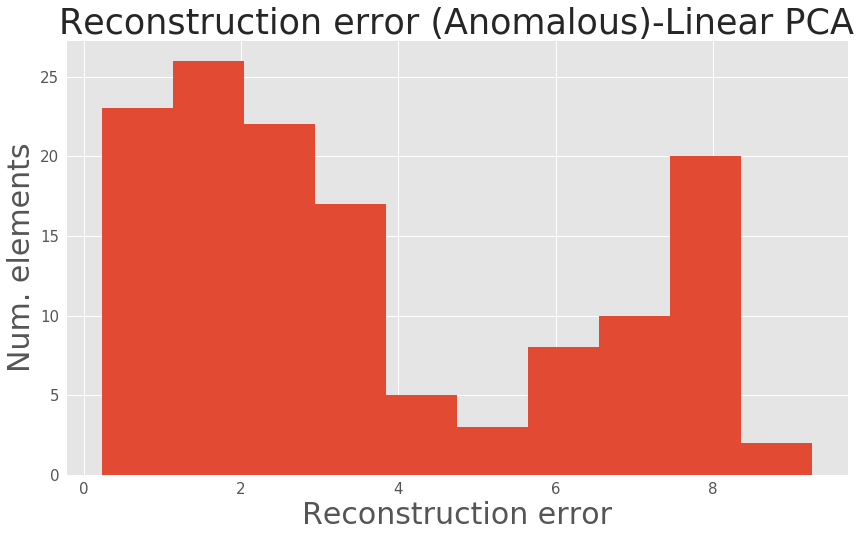

In [28]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    anom_error_df_pca = error_df_pca[error_df_pca['true_class'] == 1]
    _ = ax.hist(anom_error_df_pca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Linear PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

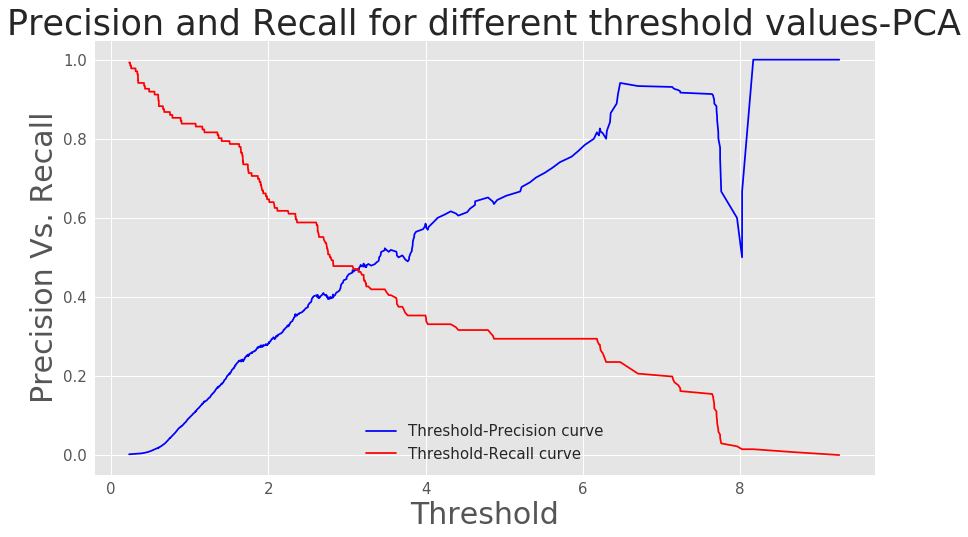

In [29]:
precision_pca, recall_pca, th_pca = precision_recall_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
with plt.style.context('ggplot'):
    plt.plot(th_pca, precision_pca[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_pca, recall_pca[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision and Recall for different threshold values-PCA', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)
    plt.legend(loc='best')

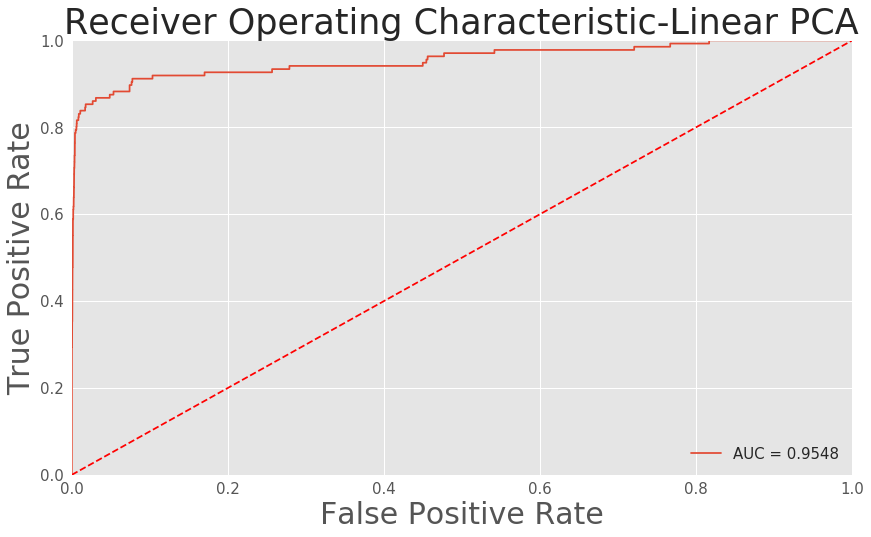

In [30]:
fpr_pca, tpr_pca, thresholds_pca = roc_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
roc_auc_pca = auc(fpr_pca, tpr_pca)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Linear PCA', size=35)
    plt.plot(fpr_pca, tpr_pca, label='AUC = %0.4f'% roc_auc_pca)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size=30)
    plt.xlabel('False Positive Rate', size=30)

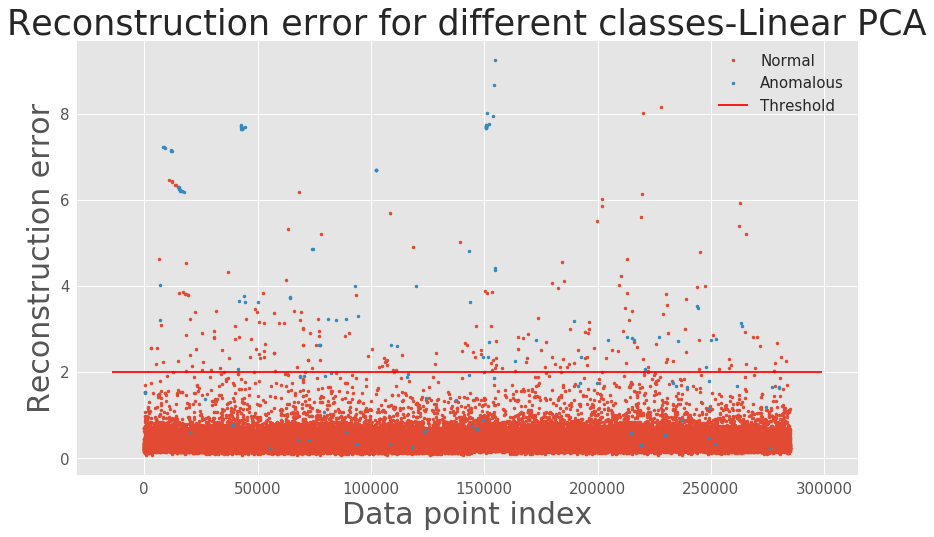

In [31]:
threshold = 2
groups = error_df_pca.groupby('true_class')
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Anomalous" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-Linear PCA", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)

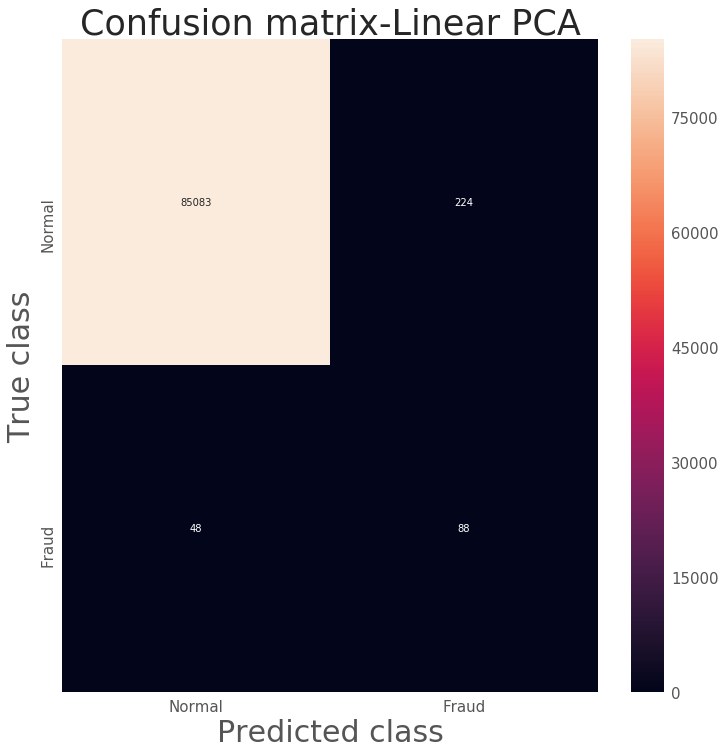

In [32]:
y_pred_pca = [1 if e > threshold else 0 for e in error_df_pca.reconstruction_error.values]
conf_matrix_pca = confusion_matrix(error_df_pca.true_class, y_pred_pca)
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix_pca, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix-Linear PCA", size = 35)
    plt.ylabel('True class', size = 30)
    plt.xlabel('Predicted class', size = 30)

In [33]:
AE = AutoEncoder(num_features=X_train.shape[1], num_latent_node = 7,activation_fun='relu',  lamda = 10**-5)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
AE.model_settings()
AE.setting_train_test_DS(X_train, X_test)

In [35]:
history_AE = AE.fit(epochs=1000,batch_size=256).history

Train on 199008 samples, validate on 85443 samples
Epoch 1/1000
199008/199008 [==============================] - 3s 14us/sample - loss: 0.8192 - mean_squared_error: 0.8191 - val_loss: 0.6713 - val_mean_squared_error: 0.6712
Epoch 2/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.5738 - mean_squared_error: 0.5737 - val_loss: 0.5738 - val_mean_squared_error: 0.5737
Epoch 3/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.5185 - mean_squared_error: 0.5185 - val_loss: 0.5450 - val_mean_squared_error: 0.5450
Epoch 4/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.5026 - mean_squared_error: 0.5025 - val_loss: 0.5367 - val_mean_squared_error: 0.5366
Epoch 5/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.4978 - mean_squared_error: 0.4977 - val_loss: 0.5334 - val_mean_squared_error: 0.5334
Epoch 6/1000
199008/199008 [==============================] - 2s 12us/sample - loss:

In [36]:
AE.predict()

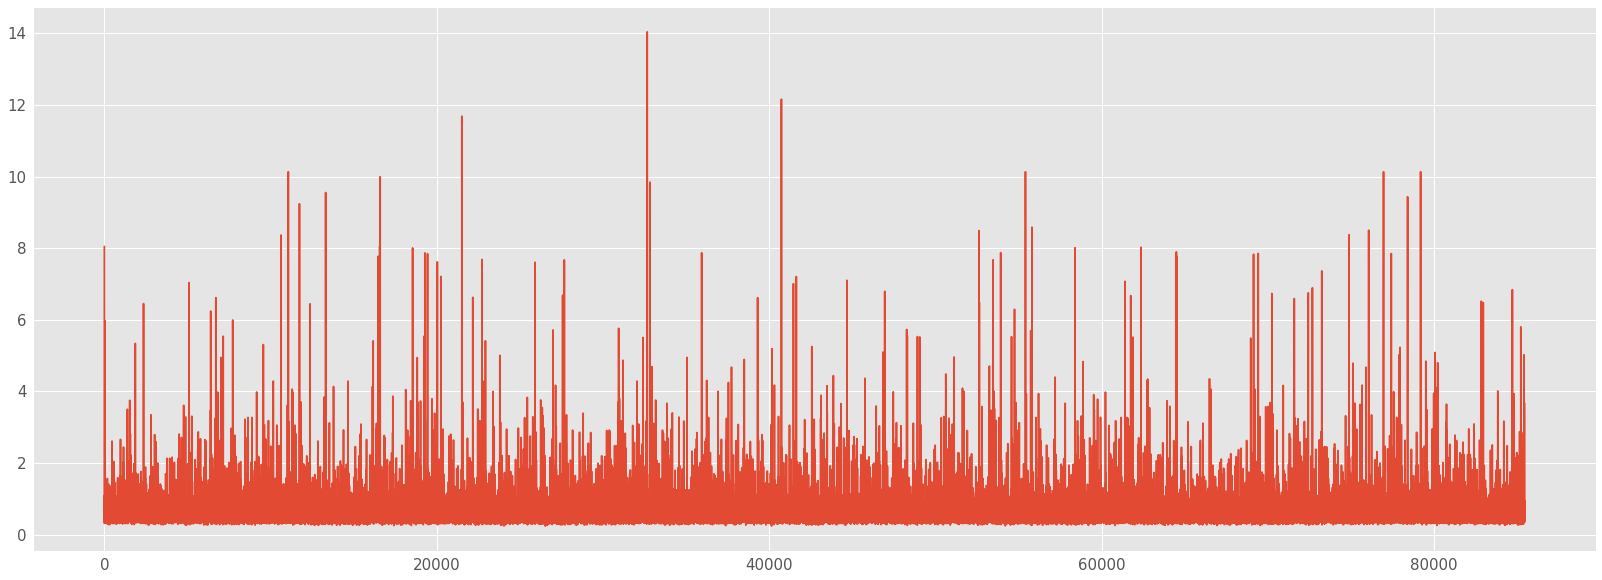

In [37]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE.get_error_recustruction_test())

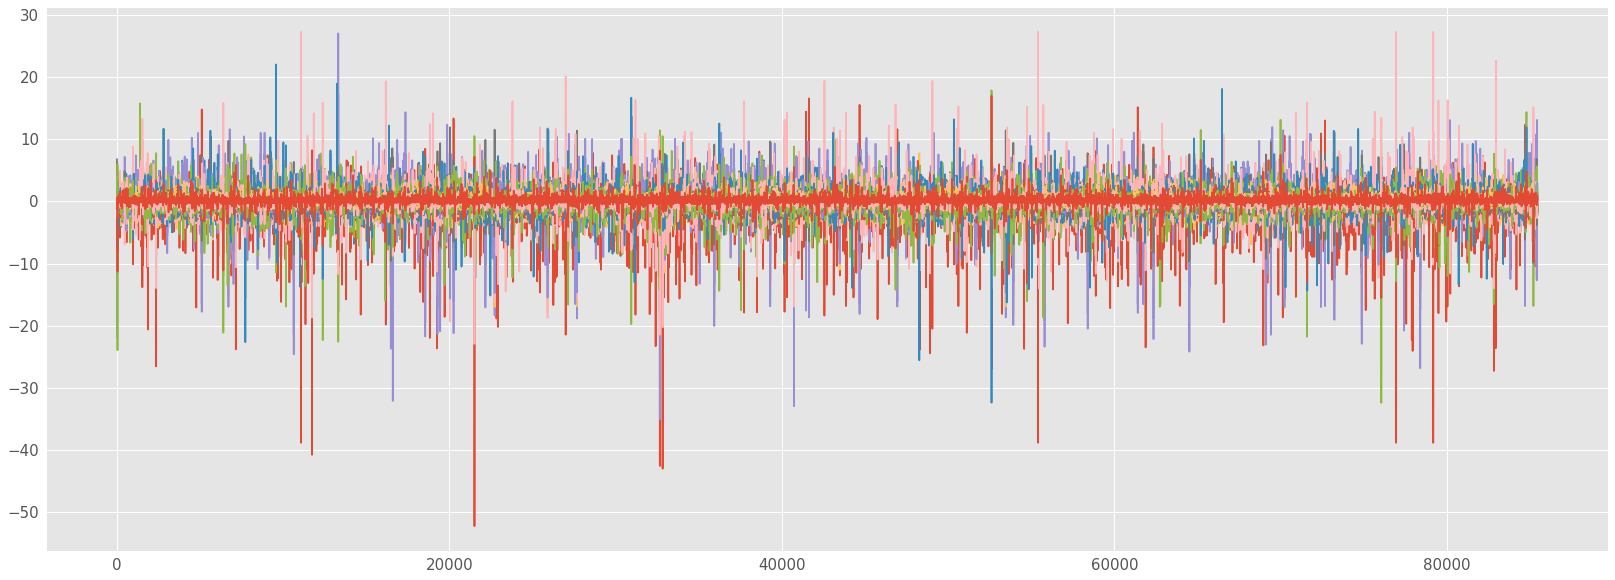

In [38]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-AE.X_test_hat)
    

In [39]:
(AE.X_test-AE.X_test_hat).shape

(85443, 29)

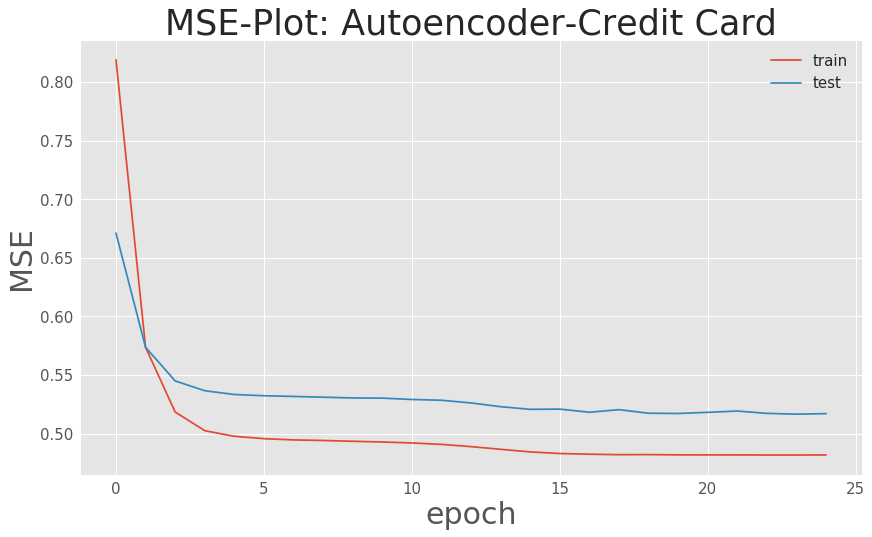

In [40]:
with plt.style.context('ggplot'):
    plt.plot(history_AE['mean_squared_error'])
    plt.plot(history_AE['val_mean_squared_error'])
    plt.title('MSE-Plot: Autoencoder-Credit Card', size = 35)
    plt.ylabel('MSE', size = 30)
    plt.xlabel('epoch', size = 30)
    plt.legend(['train', 'test'], loc='upper right')


In [41]:
mse_AE = AE.get_error_recustruction_test()
error_df_AE = pd.DataFrame({'reconstruction_error': mse_AE,
                        'true_class': y_test})
error_df_AE.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.620158,0.001592
std,0.363957,0.039865
min,0.240372,0.000000
25%,0.449473,0.000000
50%,0.555763,0.000000
75%,0.699853,0.000000
max,14.037094,1.000000


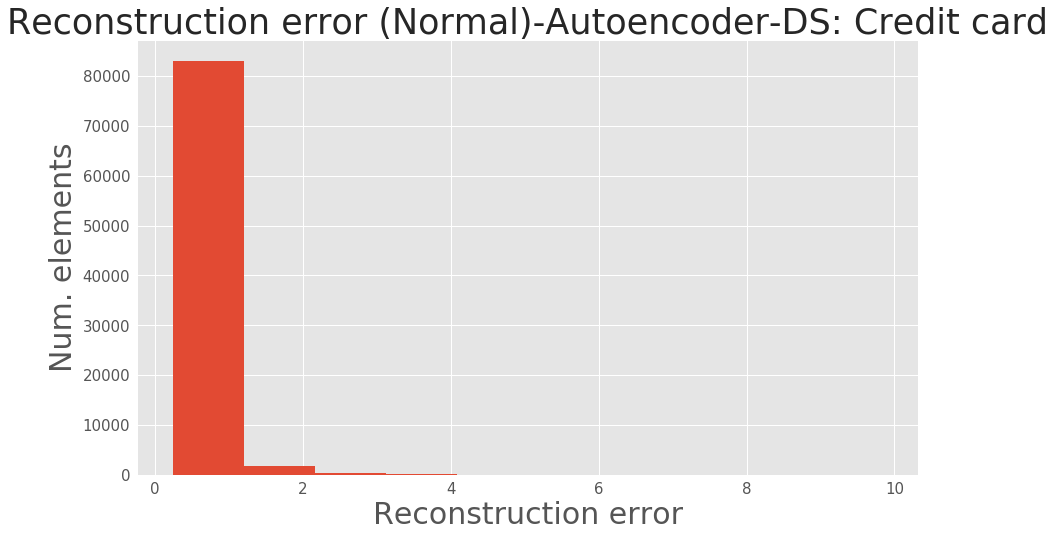

In [42]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df = error_df_AE[(error_df_AE['true_class']== 0) & (error_df_AE['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)-Autoencoder-DS: Credit card', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

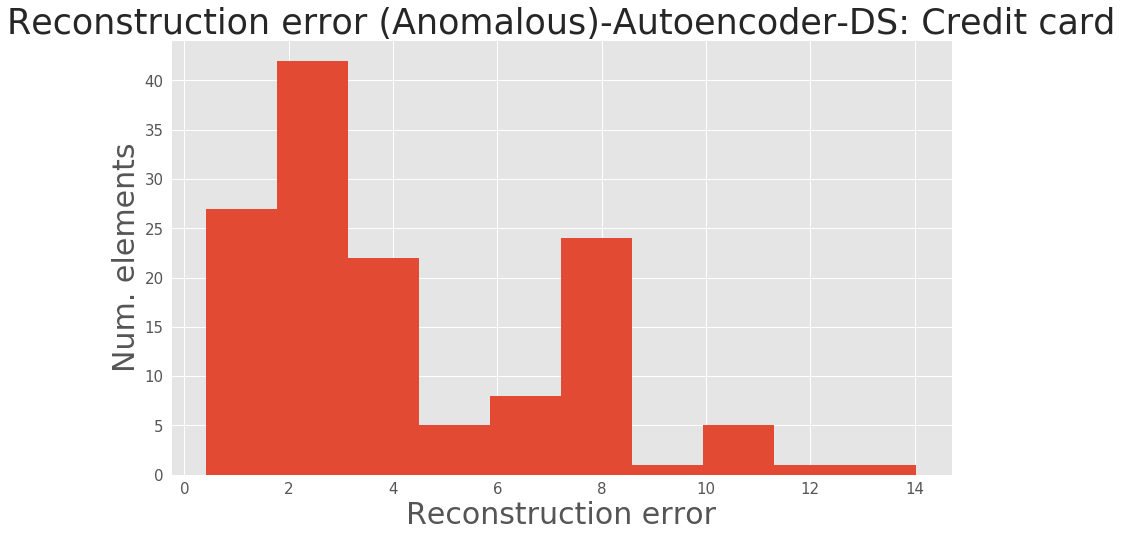

In [43]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fraud_error_df_AE = error_df_AE[error_df_AE['true_class'] == 1]
    _ = ax.hist(fraud_error_df_AE.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Autoencoder-DS: Credit card', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

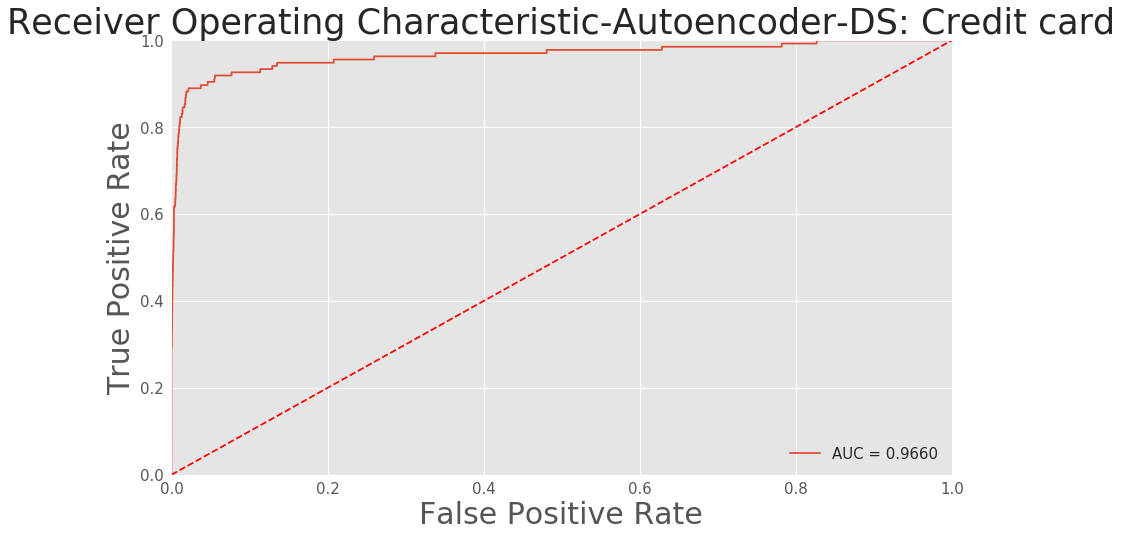

In [44]:
fpr_AE, tpr_AE, thresholds_AE = roc_curve(error_df_AE.true_class, error_df_AE.reconstruction_error)
precision_AE, recall_AE, th_AE = precision_recall_curve(error_df_AE.true_class, error_df_AE.reconstruction_error)
roc_auc_AE = auc(fpr_AE, tpr_AE)

with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Autoencoder-DS: Credit card', size = 35)
    plt.plot(fpr_AE, tpr_AE, label='AUC = %0.4f'% roc_auc_AE)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size = 30)
    plt.xlabel('False Positive Rate', size = 30)


In [45]:
np.round_(th_AE, decimals=4)

array([ 0.4186,  0.4186,  0.4186, ..., 11.6843, 12.1583, 14.0371])

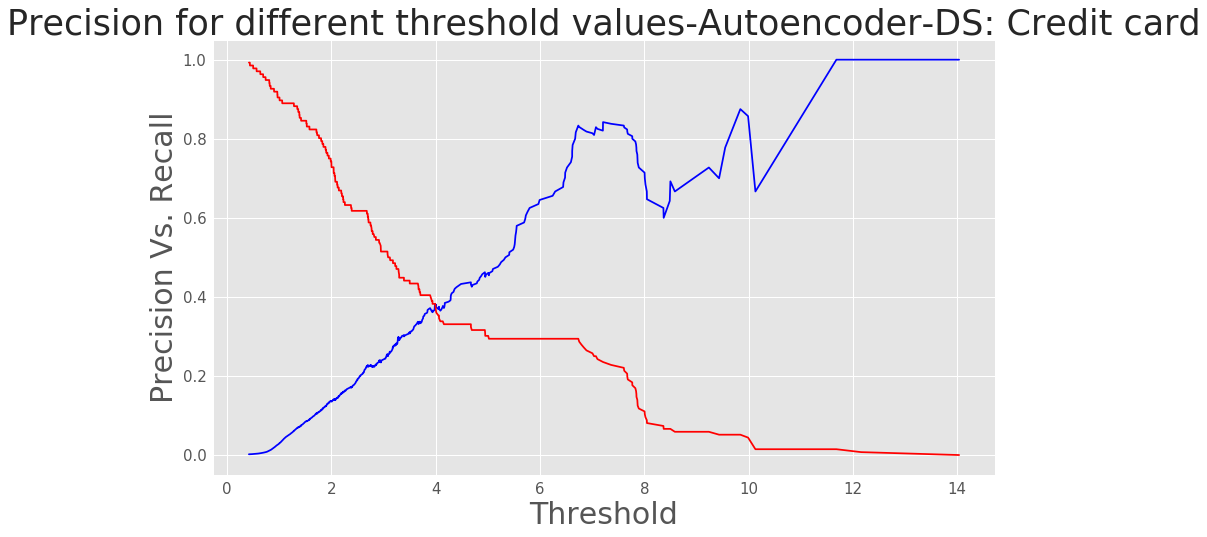

In [46]:
with plt.style.context('ggplot'):
    plt.plot(th_AE, precision_AE[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_AE, recall_AE[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision for different threshold values-Autoencoder-DS: Credit card', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)


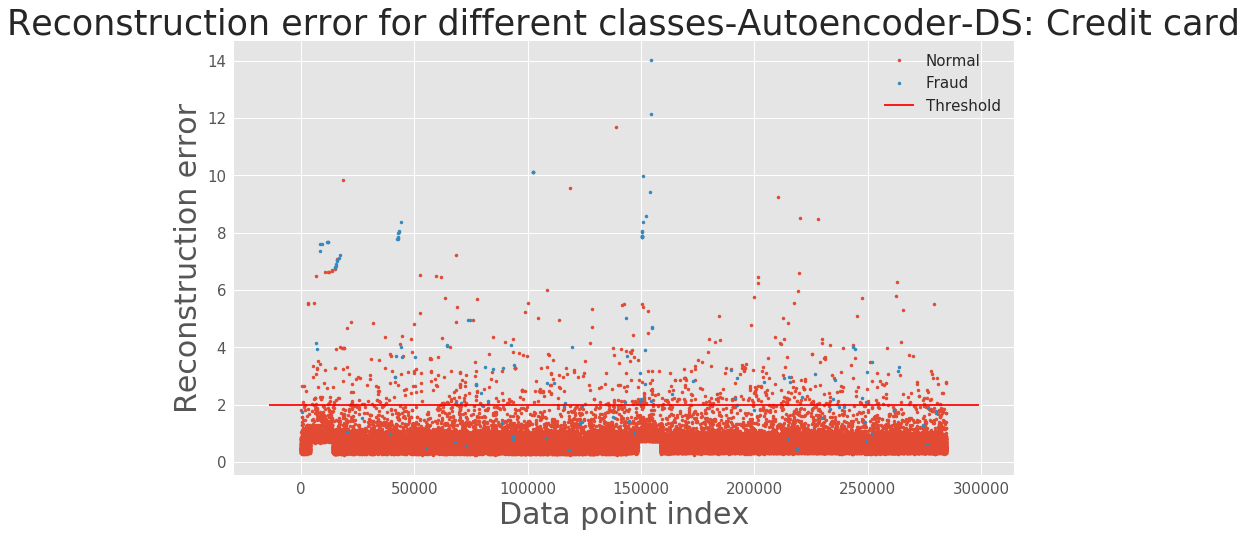

In [47]:
threshold = 2
with plt.style.context('ggplot'):
    groups_AE = error_df_AE.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups_AE:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-Autoencoder-DS: Credit card", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)


Text(0.5, 82.0, 'Predicted class')

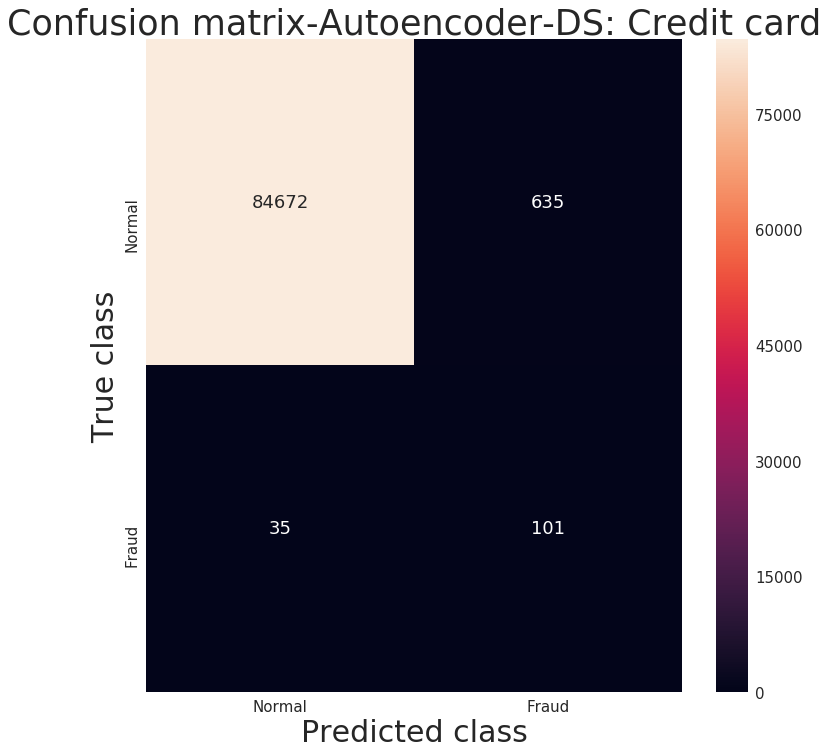

In [48]:
y_pred_AE = [1 if e > threshold else 0 for e in error_df_AE.reconstruction_error.values]
conf_matrix_AE = confusion_matrix(error_df_AE.true_class, y_pred_AE)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_AE, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix-Autoencoder-DS: Credit card", size = 35)
plt.ylabel('True class', size = 30)
plt.xlabel('Predicted class', size = 30)


In [49]:
AE_denoising = AutoEncoder(num_features=X_train.shape[1],num_latent_node=X_train.shape[1]*2, lamda = 10**-5)
AE_denoising.model_settings()
#X_train_noise = random_noise(X_train, mode='pepper')
X_train_noise = noisy.noisy("gauss" ,X_train)
AE_denoising.setting_train_test_DS(X_train_noise, X_test)

In [50]:
history_denoising = AE_denoising.fit(epochs=1000,batch_size=256).history

Train on 199008 samples, validate on 85443 samples
Epoch 1/1000
199008/199008 [==============================] - 3s 14us/sample - loss: 0.3550 - mean_squared_error: 0.3546 - val_loss: 0.0676 - val_mean_squared_error: 0.0672
Epoch 2/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.0376 - mean_squared_error: 0.0372 - val_loss: 0.0156 - val_mean_squared_error: 0.0153
Epoch 3/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.0097 - mean_squared_error: 0.0094 - val_loss: 0.0047 - val_mean_squared_error: 0.0044
Epoch 4/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.0032 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_squared_error: 0.0016
Epoch 5/1000
199008/199008 [==============================] - 2s 12us/sample - loss: 0.0013 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_error: 7.8592e-04
Epoch 6/1000
199008/199008 [==============================] - 2s 12us/sample - l

In [51]:
AE_denoising.predict()

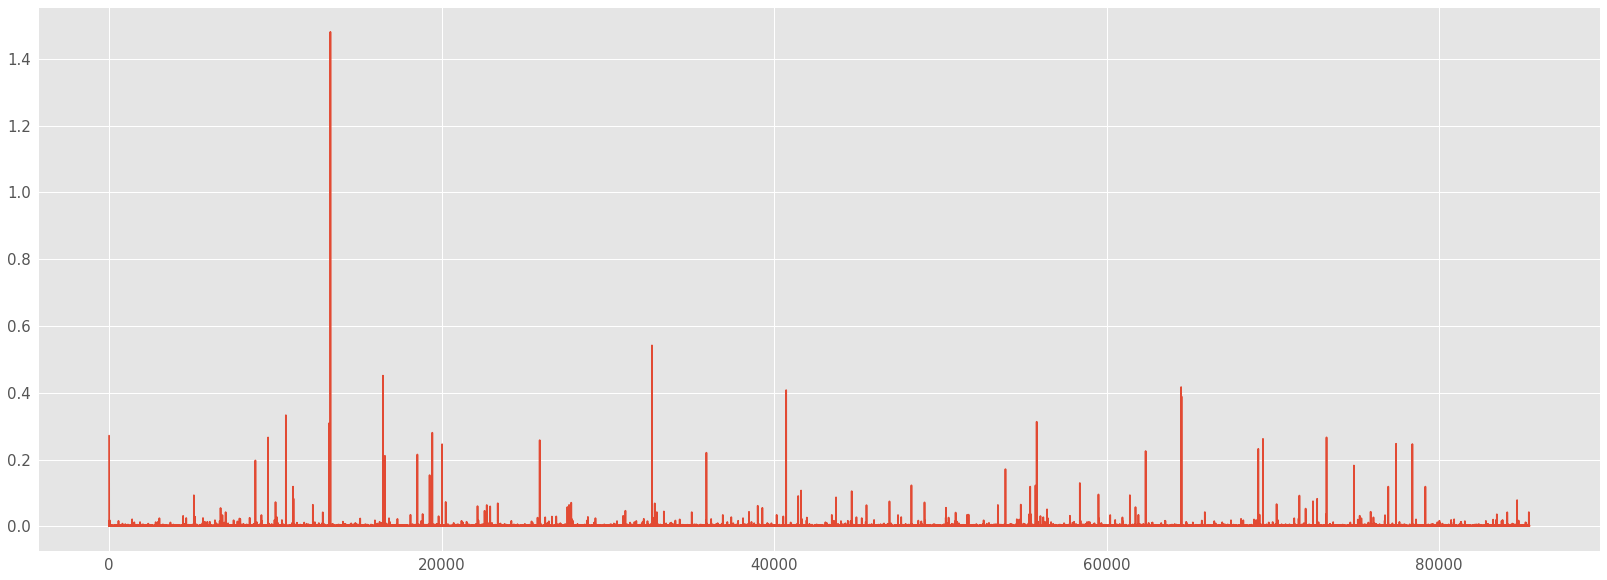

In [52]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE_denoising.get_error_recustruction_test())

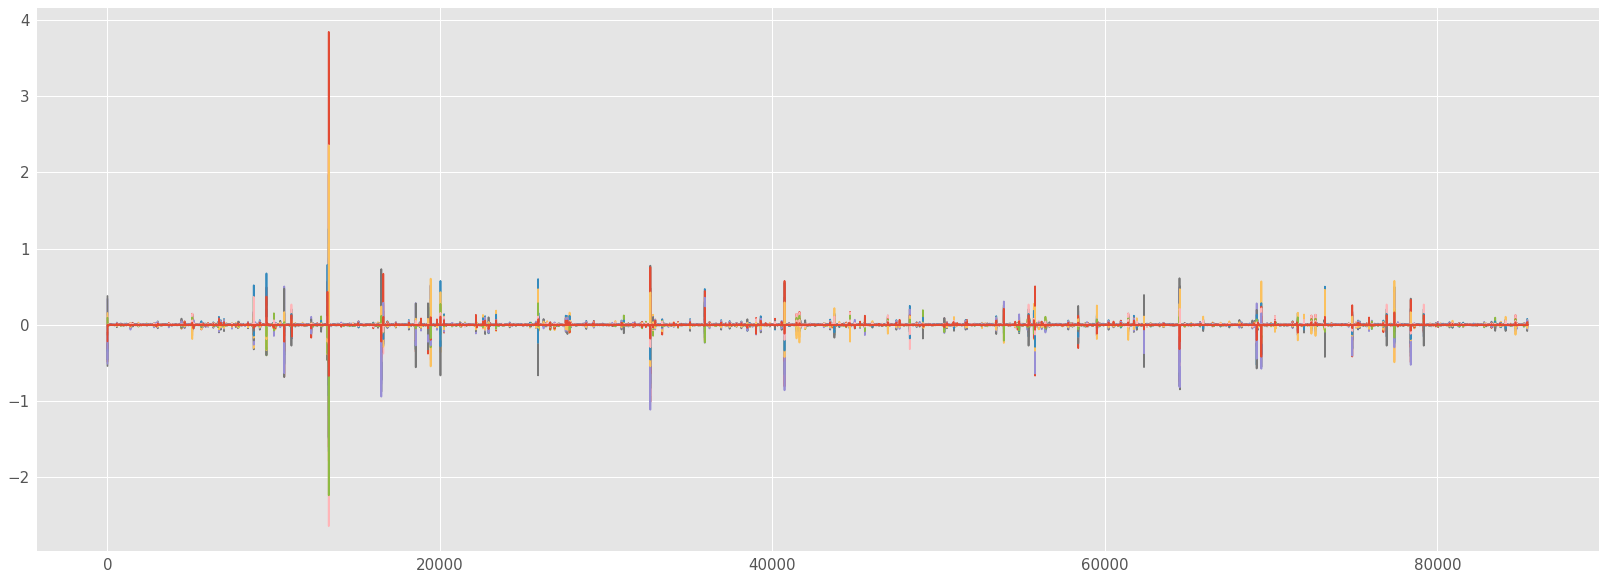

In [53]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-AE_denoising.X_test_hat)

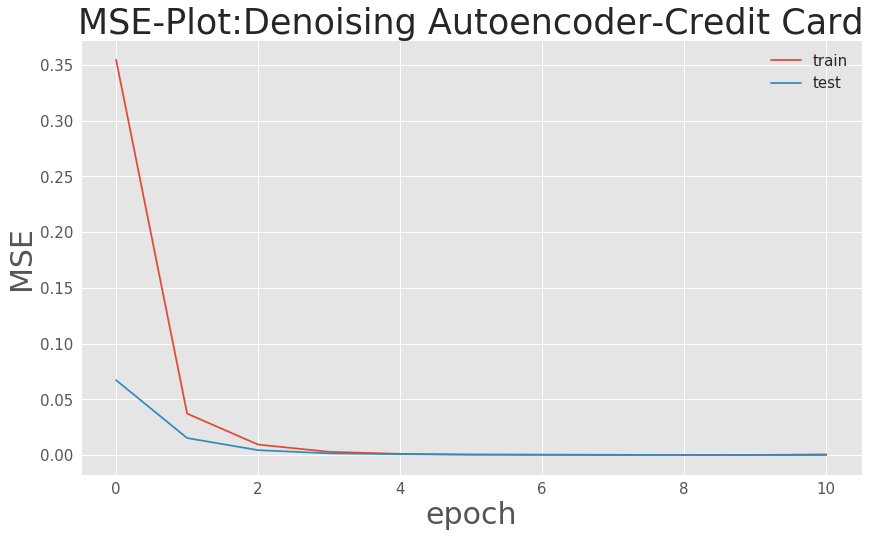

In [54]:
with plt.style.context('ggplot'):
    plt.plot(history_denoising['mean_squared_error'])
    plt.plot(history_denoising['val_mean_squared_error'])
    plt.title('MSE-Plot:Denoising Autoencoder-Credit Card', size = 35)
    plt.ylabel('MSE', size = 30)
    plt.xlabel('epoch', size = 30)
    plt.legend(['train', 'test'], loc='upper right')


In [55]:
mse_DAE = AE_denoising.get_error_recustruction_test()#np.mean(np.power(X_test - AE_denoising.X_test_hat, 2), axis=1)
error_df_DAE = pd.DataFrame({'reconstruction_error': mse_DAE,
                        'true_class': y_test})
error_df_DAE.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.001573,0.001592
std,0.007543,0.039865
min,0.000665,0.000000
25%,0.001079,0.000000
50%,0.001252,0.000000
75%,0.001504,0.000000
max,1.480479,1.000000


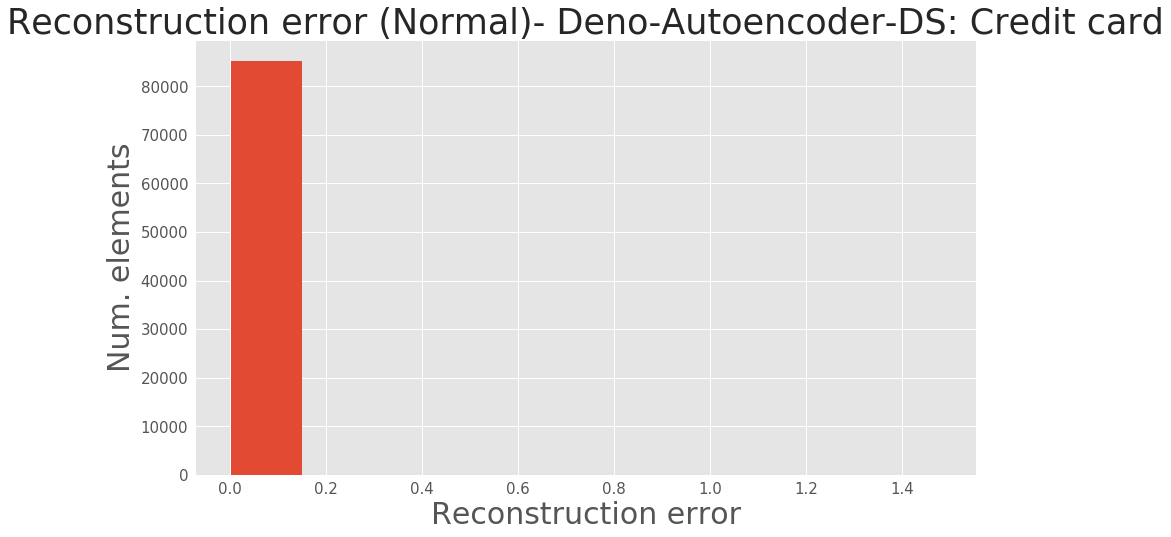

In [56]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_DAE = error_df_DAE[(error_df_DAE['true_class']== 0) & (error_df_DAE['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df_DAE.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)- Deno-Autoencoder-DS: Credit card', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

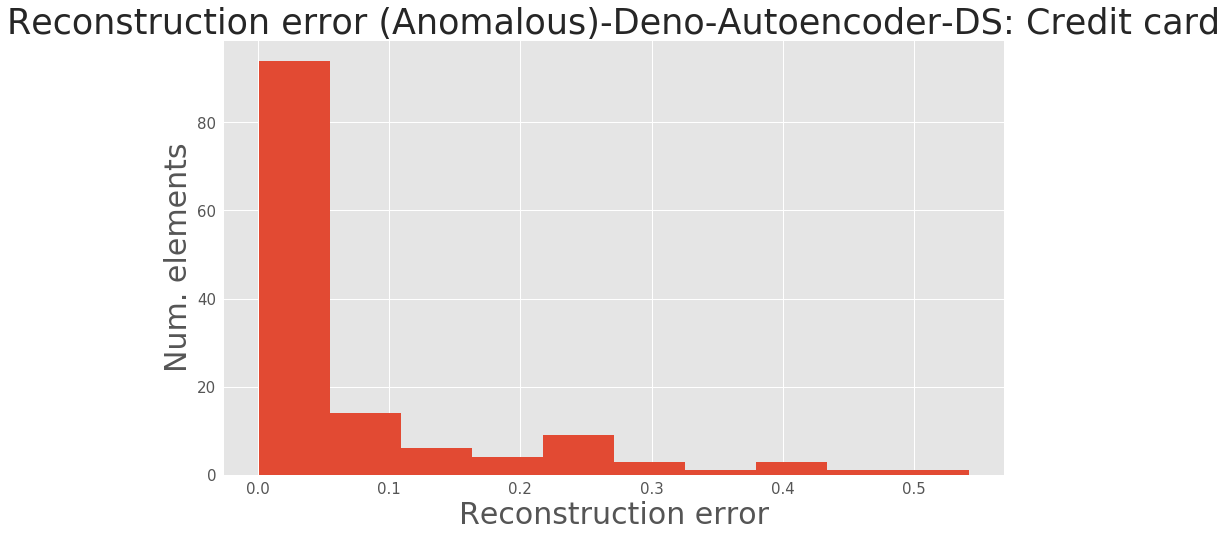

In [57]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fraud_error_df_DAE = error_df_DAE[error_df_DAE['true_class'] == 1]
    _ = ax.hist(fraud_error_df_DAE.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Deno-Autoencoder-DS: Credit card', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

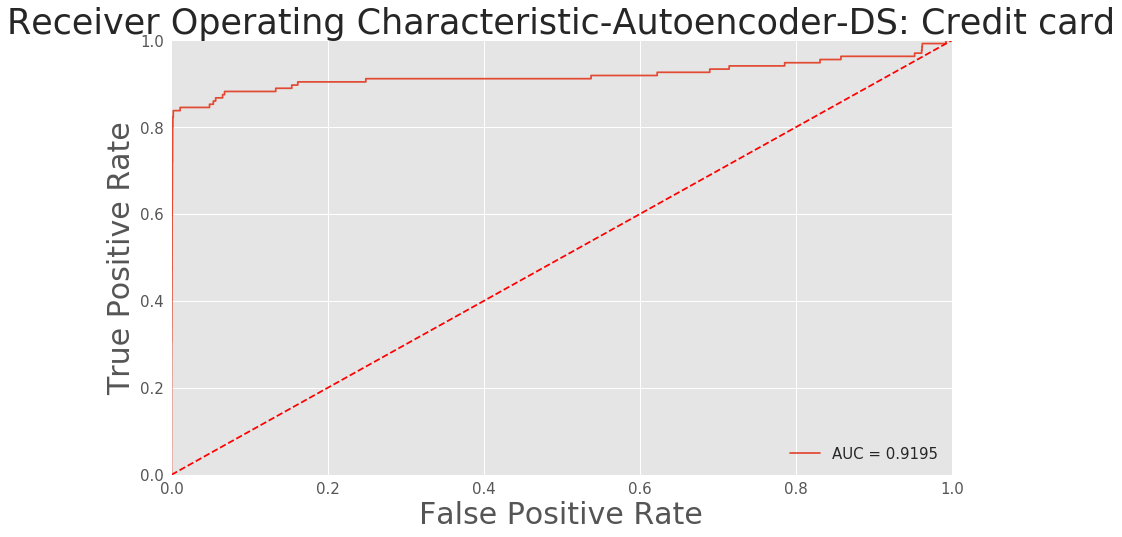

In [58]:
fpr_DAE, tpr_DAE, thresholds_DAE = roc_curve(error_df_DAE.true_class, error_df_DAE.reconstruction_error)
precision_DAE, recall_DAE, th_DAE = precision_recall_curve(error_df_DAE.true_class, error_df_DAE.reconstruction_error)
roc_auc_DAE = auc(fpr_DAE, tpr_DAE)

with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Autoencoder-DS: Credit card', size = 35)
    plt.plot(fpr_DAE, tpr_DAE, label='AUC = %0.4f'% roc_auc_DAE)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size = 30)
    plt.xlabel('False Positive Rate', size = 30)

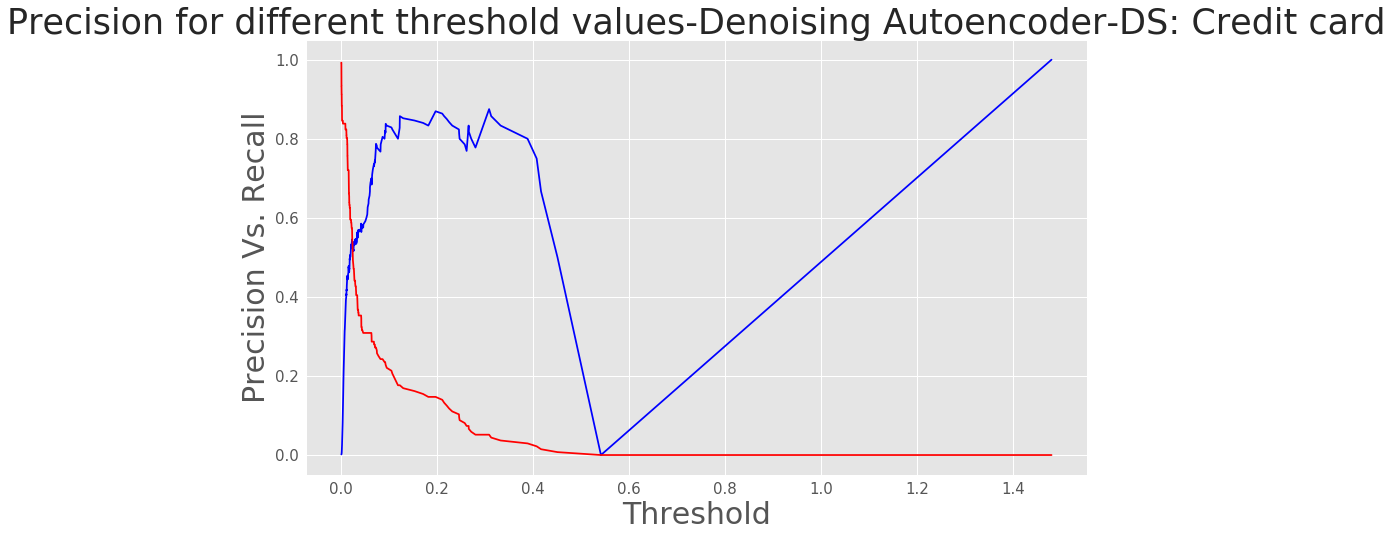

In [91]:
with plt.style.context('ggplot'):
    plt.plot(th_DAE, precision_DAE[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_DAE, recall_DAE[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision for different threshold values-Denoising Autoencoder-DS: Credit card', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)


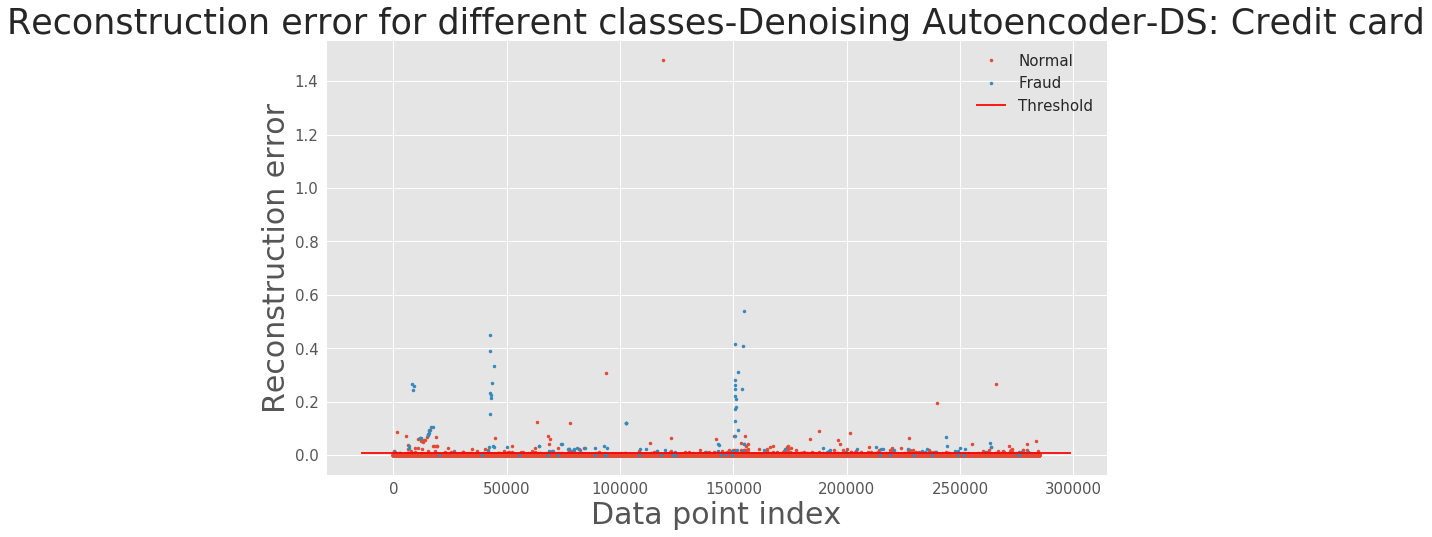

In [92]:
threshold = 0.009
with plt.style.context('ggplot'):
    groups_DAE = error_df_DAE.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups_DAE:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-Denoising Autoencoder-DS: Credit card", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)


Text(0.5, 82.0, 'Predicted class')

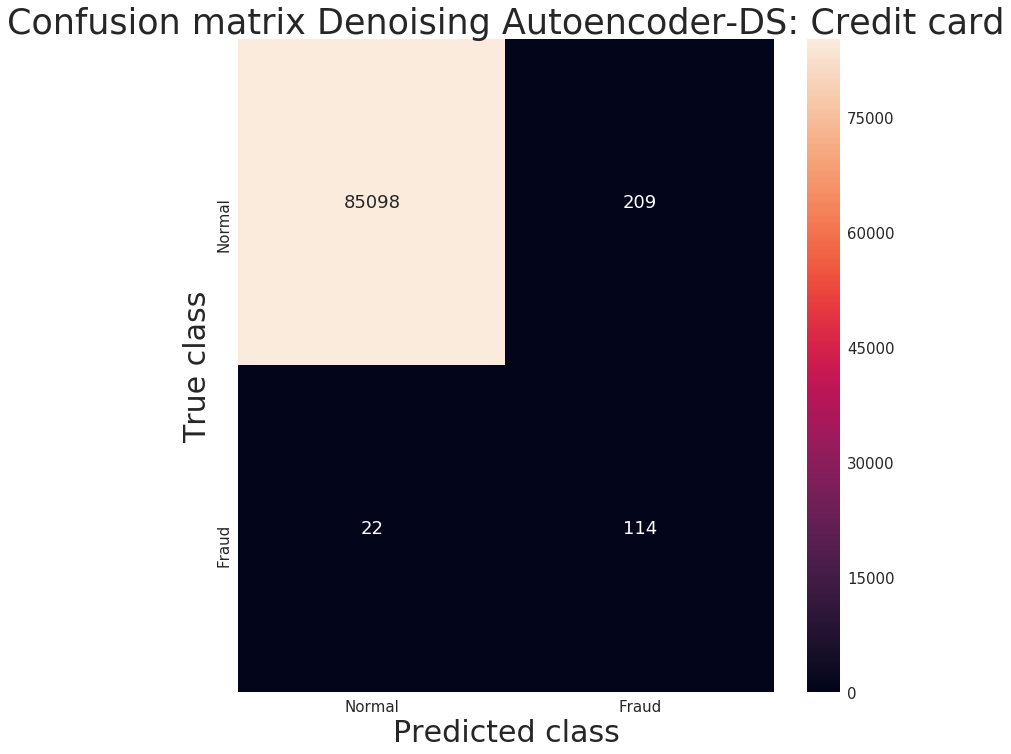

In [96]:
y_pred_DAE = [1 if e > threshold else 0 for e in error_df_DAE.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_DAE.true_class, y_pred_DAE)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix Denoising Autoencoder-DS: Credit card",size =35)
plt.ylabel('True class', size=30)
plt.xlabel('Predicted class',size=30)

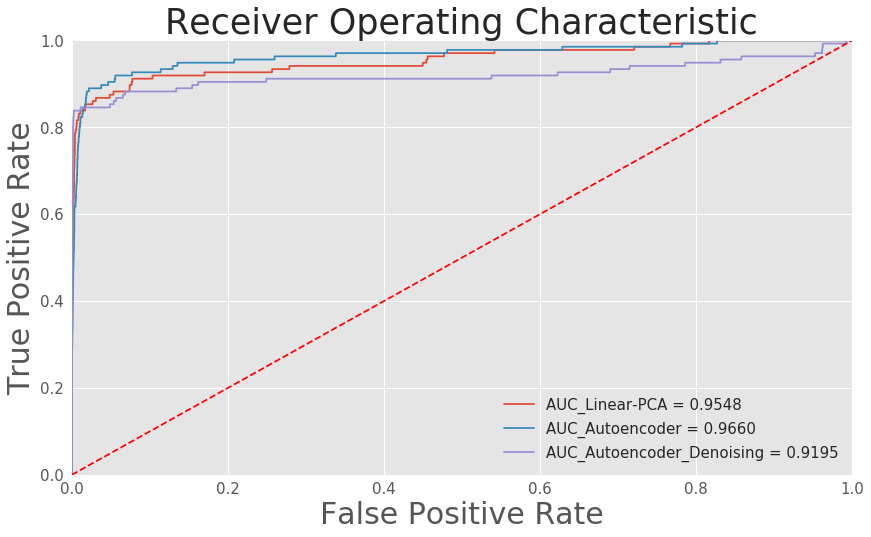

In [84]:
fpr_pca, tpr_pca, thresholds_pca = roc_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
roc_auc_pca = auc(fpr_pca, tpr_pca)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic', size=35)
    plt.plot(fpr_pca, tpr_pca, label='AUC_Linear-PCA = %0.4f'% roc_auc_pca)
    plt.plot(fpr_AE, tpr_AE, label='AUC_Autoencoder = %0.4f'% roc_auc_AE)
    plt.plot(fpr_DAE, tpr_DAE, label='AUC_Autoencoder_Denoising = %0.4f'% roc_auc_DAE)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size=30)
    plt.xlabel('False Positive Rate', size=30)